First we source all the files and read in the power [Ajna and Coolan] and cpu data
The following document contains the queries that were used for the raw data:
https://salesforce.quip.com/Imk6AVRaTLDt

In [1]:
MS_IN_SECS=1000
options(repr.plot.width=6.5, repr.plot.height=4)
options(digits=2)
library(zoo)
source_file_dir='/Users/abertran/Documents/gitRepositories/TTL_prod_code/'
source(paste(source_file_dir,"readPodCSVDataPower.R",sep=""))
source(paste(source_file_dir,"readHostCSVDataCpu.R",sep=""))
source(paste(source_file_dir,"readHostCSVDataPowerCoolan.R",sep=""))
data_dir='/Users/abertran/Documents/Data/Power_data/'



Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



In [2]:
file_name='power_eu5.csv'
data=readPodCSVDataPower(data_dir,file_name)
file_name='power_coolan_eu5'
data_coolan= readHostCSVDataPowerCoolan(data_dir,file_name)
file_name='eu5_cpu'
data_cpu=readHostCSVDataCpu(data_dir,file_name)
#Remove cpu's >100
data_cpu = data_cpu[which(data_cpu$cpu<=100),]

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“not all columns named in 'colClasses' exist”Warning message in readPodCSVDataPower(data_dir, file_name):
“NAs introduced by coercion”Warning message in readPodCSVDataPower(data_dir, file_name):
“NAs introduced by coercion”Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“not all columns named in 'colClasses' exist”

In [3]:
hostname='eu5-app1-12-par.ops.sfdc.net' #"eu5-app1-12-par.ops.sfdc.net"
#Ajna power
host_data=data[which(data$hostname==hostname),]
host_data$total_power_smoothed=rollmean(host_data$total_power,k=3,fill=NA)
host_data$total_power_smoothed_9=rollmean(host_data$total_power,k=9,fill=NA)
#CPU
host_data_cpu=data_cpu[which(data_cpu$hostname=="eu5-app1-12-par.ops.sfdc.net"),]
#CPU data has more data; make them stop at the same date
q=which(host_data_cpu$timestamp > max(host_data$timestamp))
host_data_cpu=host_data_cpu[1:(min(q)-1),]
host_data_cpu$cpu_smoothed=rollmedian(host_data_cpu$cpu,k=3,fill=NA)
host_data_cpu$cpu_smoothed_9=rollmedian(host_data_cpu$cpu,k=9,fill=NA)
#Coolan power
host_data_coolan=data_coolan[which(data_coolan$hostname==hostname),]
q=which((host_data_coolan$timestamp<=max(host_data$timestamp)) & (host_data_coolan$timestamp>=min(host_data$timestamp)))
host_data_coolan=host_data_coolan[q,]

It appears the Ajna and Coolan power data is quantized to 5 Watts, which is why for the Ajna power we can try to smooth it to improve the correlation between cpu and power.

In [4]:
sort(unique(host_data$total_power))
sort(unique(host_data_coolan$total_power))

[1] 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335
[20] 340 345 350 355 360 365 370 375 380 385 390 395 400 410 435

[1] 280 285 290 295 300 305 310 315 320 325 330 335

Let's plot the data for one app host unsmoothed (black dots) vs smoothed (red lines)

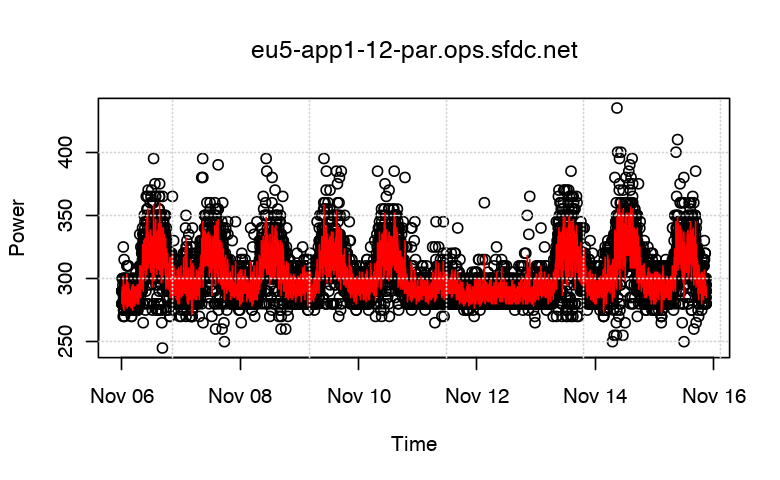

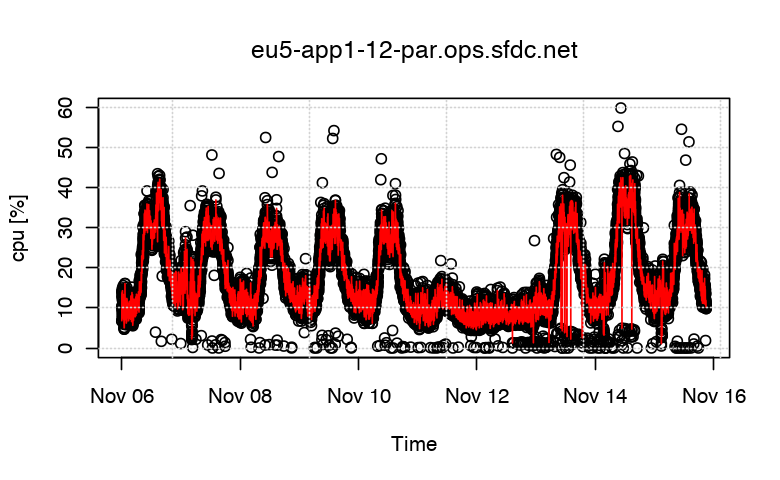

In [5]:
plot(host_data$timestamp,host_data$total_power,xlab='Time',ylab='Power')
lines(host_data$timestamp,host_data$total_power_smoothed,col="red")
grid()
title(hostname)

plot(host_data_cpu$timestamp, host_data_cpu$cpu,xlab='Time',ylab='cpu [%]')
lines(host_data_cpu$timestamp,host_data_cpu$cpu_smoothed,col="red")
grid()
title(hostname)

Let's compare Coolan vs Ajna power

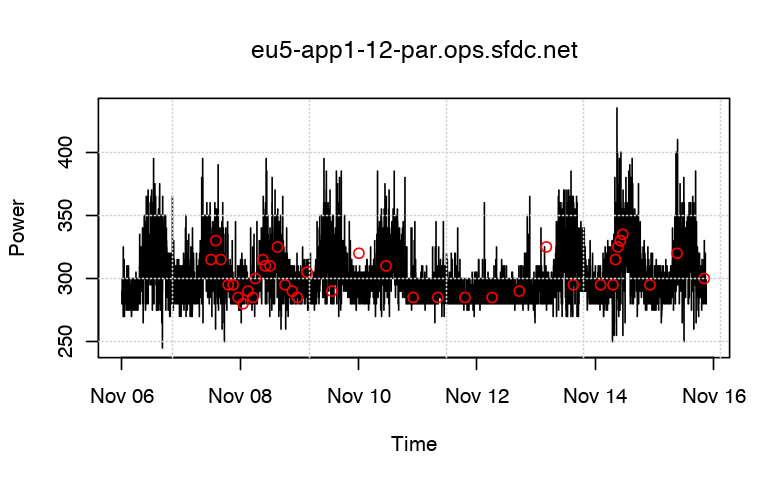

In [6]:
plot(host_data$timestamp,host_data$total_power,xlab='Time',ylab='Power',ty="l")
points(host_data_coolan$timestamp, host_data_coolan$total_power,col="red")#,pch='.'
grid()
title(hostname)

Coolan seems to have a lot of missing data in our system at least for this particularly randomly picked host.

Let's look at the correlation for one app host

In [7]:
total_power_norm=(host_data$total_power-mean(host_data$total_power,na.rm=TRUE))/sd(host_data$total_power,na.rm=TRUE)
cpu_norm=(host_data_cpu$cpu-mean(host_data_cpu$cpu,na.rm=TRUE))/sd(host_data_cpu$cpu,na.rm=TRUE)
corr_unsmoothed=ccf(total_power_norm,cpu_norm,lag.max=10,type="correlation", na.action = na.pass,plot=FALSE)
corr_unsmoothed=max(corr_unsmoothed$acf)
#k=3
total_power_norm_sm=(host_data$total_power_smoothed-mean(host_data$total_power_smoothed,na.rm=TRUE))/sd(host_data$total_power_smoothed,na.rm=TRUE)
cpu_norm_sm=(host_data_cpu$cpu_smoothed-mean(host_data_cpu$cpu_smoothed,na.rm=TRUE))/sd(host_data_cpu$cpu_smoothed,na.rm=TRUE)
corr_smoothed=ccf(total_power_norm_sm,cpu_norm_sm,lag.max=10,type="correlation", na.action = na.pass,plot=FALSE)
corr_smoothed=max(corr_smoothed$acf)
#k=9
total_power_norm_sm_9=(host_data$total_power_smoothed_9-mean(host_data$total_power_smoothed_9,na.rm=TRUE))/sd(host_data$total_power_smoothed_9,na.rm=TRUE)
cpu_norm_sm_9=(host_data_cpu$cpu_smoothed_9-mean(host_data_cpu$cpu_smoothed_9,na.rm=TRUE))/sd(host_data_cpu$cpu_smoothed_9,na.rm=TRUE)
corr_smoothed_9=ccf(total_power_norm_sm_9,cpu_norm_sm_9,lag.max=10,type="correlation", na.action = na.pass,plot=FALSE)
corr_smoothed_9=max(corr_smoothed_9$acf)
print(paste("Correlations: Unsmoothed: ",corr_unsmoothed,"; Smoothed k=3: ",corr_smoothed,"; Smoothed k=9: ",corr_smoothed_9,sep=""))

[1] "Correlations: Unsmoothed: 0.684876046087055; Smoothed k=3: 0.851108770201438; Smoothed k=9: 0.932154520857136"


Let's look at a particular search host

In [8]:
hostname='eu5-search21-1-par.ops.sfdc.net' #"eu5-app1-12-par.ops.sfdc.net"
host_data=data[which(data$hostname==hostname),]
host_data$total_power_smoothed=rollmean(host_data$total_power,k=3,fill=NA)
host_data$total_power_smoothed_9=rollmean(host_data$total_power,k=9,fill=NA)
host_data_cpu=data_cpu[which(data_cpu$hostname=="eu5-app1-12-par.ops.sfdc.net"),]
#CPU data has more data; make them stop at the same date
q=which(host_data_cpu$timestamp > max(host_data$timestamp))
host_data_cpu=host_data_cpu[1:(min(q)-1),]
host_data_cpu$cpu_smoothed=rollmedian(host_data_cpu$cpu,k=3,fill=NA)
host_data_cpu$cpu_smoothed_9=rollmedian(host_data_cpu$cpu,k=9,fill=NA)
#Coolan power
host_data_coolan=data_coolan[which(data_coolan$hostname==hostname),]
q=which((host_data_coolan$timestamp<=max(host_data$timestamp)) & (host_data_coolan$timestamp>=min(host_data$timestamp)))
host_data_coolan=host_data_coolan[q,]

It appears the power data is quantized to 5 Watts, which is why we try to smooth it above to improve the correlation between cpu and power.

In [9]:
sort(unique(host_data$total_power))
sort(unique(host_data_coolan$total_power))

[1] 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330
[20] 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410

[1] 260 265 270 275 280 285 290

Let's plot the data for one search host

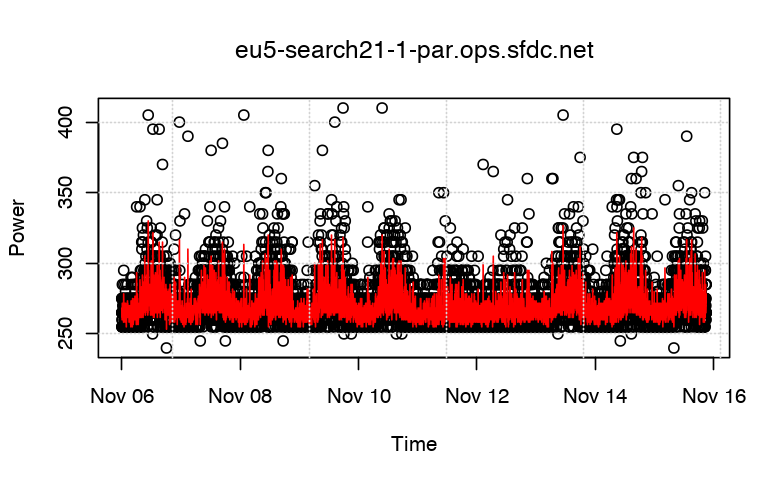

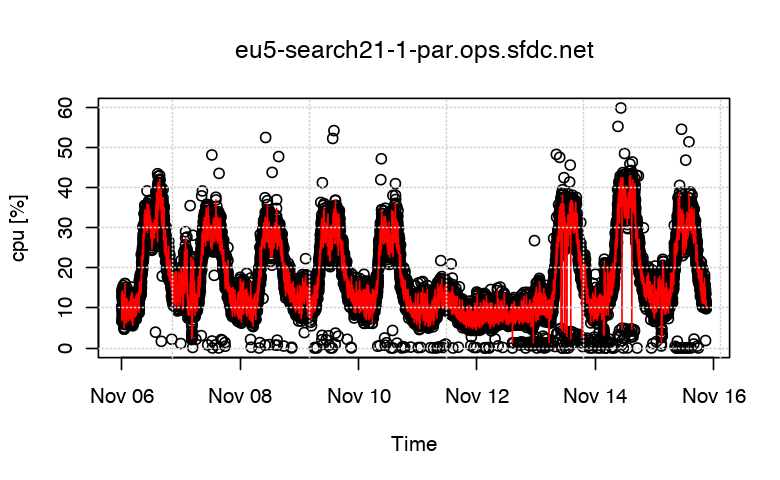

In [10]:
plot(host_data$timestamp,host_data$total_power,xlab='Time',ylab='Power')
lines(host_data$timestamp,host_data$total_power_smoothed,col="red")
grid()
title(hostname)

plot(host_data_cpu$timestamp, host_data_cpu$cpu,xlab='Time',ylab='cpu [%]')
lines(host_data_cpu$timestamp,host_data_cpu$cpu_smoothed,col="red")
grid()
title(hostname)

Again let's compare Coolan vs Ajna power for this search host

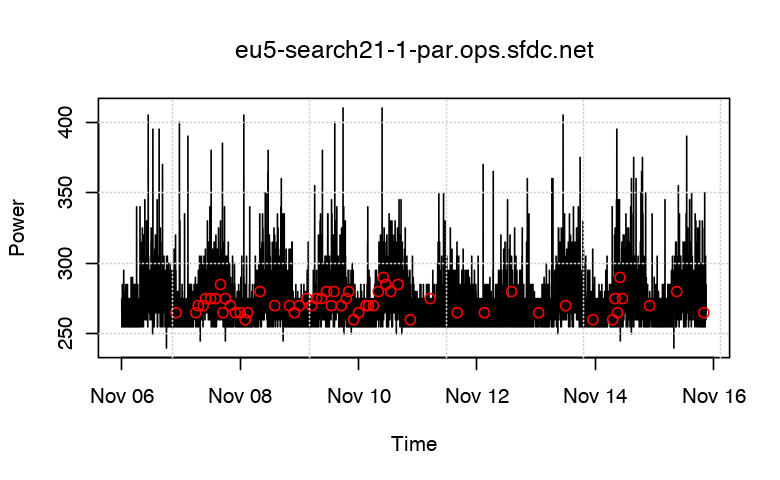

In [11]:
plot(host_data$timestamp,host_data$total_power,xlab='Time',ylab='Power',ty="l")
points(host_data_coolan$timestamp, host_data_coolan$total_power,col="red")#,pch='.'
grid()
title(hostname)

Again, Coolan data is very sparse for this search host in our system.

Let's look at the correlation for one search host

In [12]:
total_power_norm=(host_data$total_power-mean(host_data$total_power,na.rm=TRUE))/sd(host_data$total_power,na.rm=TRUE)
cpu_norm=(host_data_cpu$cpu-mean(host_data_cpu$cpu,na.rm=TRUE))/sd(host_data_cpu$cpu,na.rm=TRUE)
corr_unsmoothed=ccf(total_power_norm,cpu_norm,lag.max=10,type="correlation", na.action = na.pass,plot=FALSE)
corr_unsmoothed=max(corr_unsmoothed$acf)
#k=3
total_power_norm_sm=(host_data$total_power_smoothed-mean(host_data$total_power_smoothed,na.rm=TRUE))/sd(host_data$total_power_smoothed,na.rm=TRUE)
cpu_norm_sm=(host_data_cpu$cpu_smoothed-mean(host_data_cpu$cpu_smoothed,na.rm=TRUE))/sd(host_data_cpu$cpu_smoothed,na.rm=TRUE)
corr_smoothed=ccf(total_power_norm_sm,cpu_norm_sm,lag.max=10,type="correlation", na.action = na.pass,plot=FALSE)
corr_smoothed=max(corr_smoothed$acf)
#k=9
total_power_norm_sm_9=(host_data$total_power_smoothed_9-mean(host_data$total_power_smoothed_9,na.rm=TRUE))/sd(host_data$total_power_smoothed_9,na.rm=TRUE)
cpu_norm_sm_9=(host_data_cpu$cpu_smoothed_9-mean(host_data_cpu$cpu_smoothed_9,na.rm=TRUE))/sd(host_data_cpu$cpu_smoothed_9,na.rm=TRUE)
corr_smoothed_9=ccf(total_power_norm_sm_9,cpu_norm_sm_9,lag.max=10,type="correlation", na.action = na.pass,plot=FALSE)
corr_smoothed_9=max(corr_smoothed_9$acf)
print(paste("Correlations: Unsmoothed: ",corr_unsmoothed,"; Smoothed k=3: ",corr_smoothed,"; Smoothed k=9: ",corr_smoothed_9,sep=""))

[1] "Correlations: Unsmoothed: 0.317800353389462; Smoothed k=3: 0.511418423625665; Smoothed k=9: 0.694149385498736"


It appears the correlation is smaller in the case of search hosts vs app hosts

Let's look at a particular ffx host

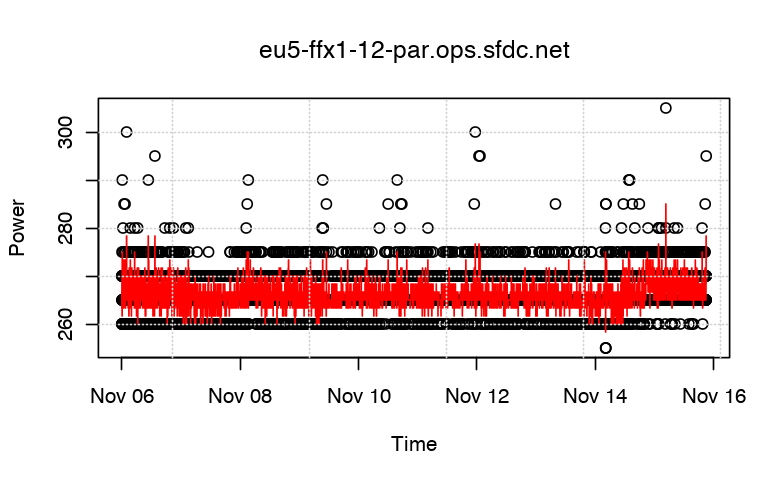

[1] "Correlations: Unsmoothed: 6.7212329736216e-06; Smoothed k=3: -0.00761245328401956; Smoothed k=9: -0.0166689937457691"


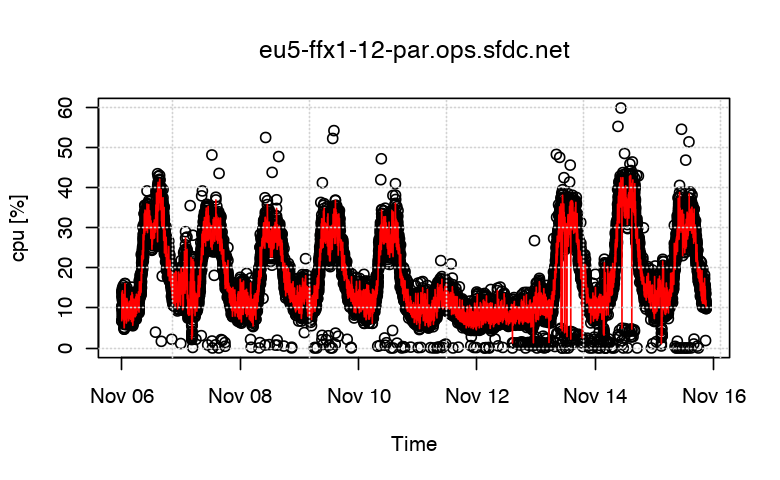

In [14]:
hostname='eu5-ffx1-12-par.ops.sfdc.net' #"eu5-app1-12-par.ops.sfdc.net"
host_data=data[which(data$hostname==hostname),]
host_data$total_power_smoothed=rollmean(host_data$total_power,k=3,fill=NA)
host_data$total_power_smoothed_9=rollmean(host_data$total_power,k=9,fill=NA)
host_data_cpu=data_cpu[which(data_cpu$hostname=="eu5-app1-12-par.ops.sfdc.net"),]
#CPU data has more data; make them stop at the same date
q=which(host_data_cpu$timestamp > max(host_data$timestamp))
host_data_cpu=host_data_cpu[1:(min(q)-1),]
host_data_cpu$cpu_smoothed=rollmedian(host_data_cpu$cpu,k=3,fill=NA)
host_data_cpu$cpu_smoothed_9=rollmedian(host_data_cpu$cpu,k=9,fill=NA)
#Coolan power
host_data_coolan=data_coolan[which(data_coolan$hostname==hostname),]
q=which((host_data_coolan$timestamp<=max(host_data$timestamp)) & (host_data_coolan$timestamp>=min(host_data$timestamp)))
host_data_coolan=host_data_coolan[q,]
plot(host_data$timestamp,host_data$total_power,xlab='Time',ylab='Power')
lines(host_data$timestamp,host_data$total_power_smoothed,col="red")
grid()
title(hostname)

plot(host_data_cpu$timestamp, host_data_cpu$cpu,xlab='Time',ylab='cpu [%]')
lines(host_data_cpu$timestamp,host_data_cpu$cpu_smoothed,col="red")
grid()
title(hostname)

total_power_norm=(host_data$total_power-mean(host_data$total_power,na.rm=TRUE))/sd(host_data$total_power,na.rm=TRUE)
cpu_norm=(host_data_cpu$cpu-mean(host_data_cpu$cpu,na.rm=TRUE))/sd(host_data_cpu$cpu,na.rm=TRUE)
corr_unsmoothed=ccf(total_power_norm,cpu_norm,lag.max=10,type="correlation", na.action = na.pass,plot=FALSE)
corr_unsmoothed=max(corr_unsmoothed$acf)
#k=3
total_power_norm_sm=(host_data$total_power_smoothed-mean(host_data$total_power_smoothed,na.rm=TRUE))/sd(host_data$total_power_smoothed,na.rm=TRUE)
cpu_norm_sm=(host_data_cpu$cpu_smoothed-mean(host_data_cpu$cpu_smoothed,na.rm=TRUE))/sd(host_data_cpu$cpu_smoothed,na.rm=TRUE)
corr_smoothed=ccf(total_power_norm_sm,cpu_norm_sm,lag.max=10,type="correlation", na.action = na.pass,plot=FALSE)
corr_smoothed=max(corr_smoothed$acf)
#k=9
total_power_norm_sm_9=(host_data$total_power_smoothed_9-mean(host_data$total_power_smoothed_9,na.rm=TRUE))/sd(host_data$total_power_smoothed_9,na.rm=TRUE)
cpu_norm_sm_9=(host_data_cpu$cpu_smoothed_9-mean(host_data_cpu$cpu_smoothed_9,na.rm=TRUE))/sd(host_data_cpu$cpu_smoothed_9,na.rm=TRUE)
corr_smoothed_9=ccf(total_power_norm_sm_9,cpu_norm_sm_9,lag.max=10,type="correlation", na.action = na.pass,plot=FALSE)
corr_smoothed_9=max(corr_smoothed_9$acf)
print(paste("Correlations: Unsmoothed: ",corr_unsmoothed,"; Smoothed k=3: ",corr_smoothed,"; Smoothed k=9: ",corr_smoothed_9,sep=""))

Let's look at use case number 1 for EU5. We will look at the relation of power vs cpu for all hosts of a certain type.

In [59]:
models=unique(data$model)
model_data=data[which(data$model==models[1]),]
hostnames=unique(model_data$hostname)
model_data_cpu= data_cpu[which(data_cpu$hostname %in% hostnames),]
q=which(model_data_cpu$timestamp <= max(model_data$timestamp))
model_data_cpu= model_data_cpu[q,]
merged_data_model=merge(model_data, model_data_cpu,by=c("timestamp","hostname"))
print (paste('Number of hosts in model ',models[1],' is ',length(hostnames),sep=""))

[1] "Number of hosts in model DL360 Gen9 is 102"


In [51]:
library(quantreg)
qr <- rq(total_power ~ cpu, data=merged_data_model, tau = 0.95)
qr2 <- rq(total_power ~ cpu, data=merged_data_model, tau = 0.99)
print(paste('95Percentile quantile regression slope, intercept: ',format(round((qr$coefficients)[2], 2), nsmall = 2),",",format(round((qr$coefficients)[1], 2), nsmall = 2),sep=""))
print(paste('99Percentile quantile regression slope, intercept: ',format(round((qr2$coefficients)[2], 2), nsmall = 2),",",format(round((qr2$coefficients)[1], 2), nsmall = 2),sep=""))

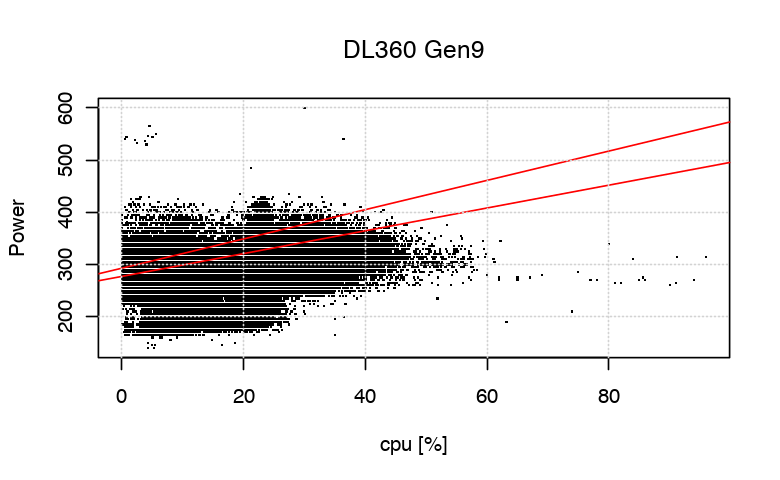

In [52]:
plot(merged_data_model$cpu, merged_data_model$total_power,xlab='cpu [%]',ylab='Power',pch='.')
abline(qr,col="red")
abline(qr2,col="red")
title(models[1])
grid()

Let's look at other models. R430 has 8 ffx hosts and 19 app hosts.

In [62]:
chosen_model=models[2]
model_data=data[which(data$model==chosen_model),]
hostnames=unique(model_data$hostname)
model_data_cpu= data_cpu[which(data_cpu$hostname %in% hostnames),]
q=which(model_data_cpu$timestamp <= max(model_data$timestamp))
model_data_cpu= model_data_cpu[q,]
merged_data_model=merge(model_data, model_data_cpu,by=c("timestamp","hostname"))
print (paste('Number of hosts in model ',chosen_model,' is ',length(hostnames),sep=""))

[1] "Number of hosts in model R430 is 27"


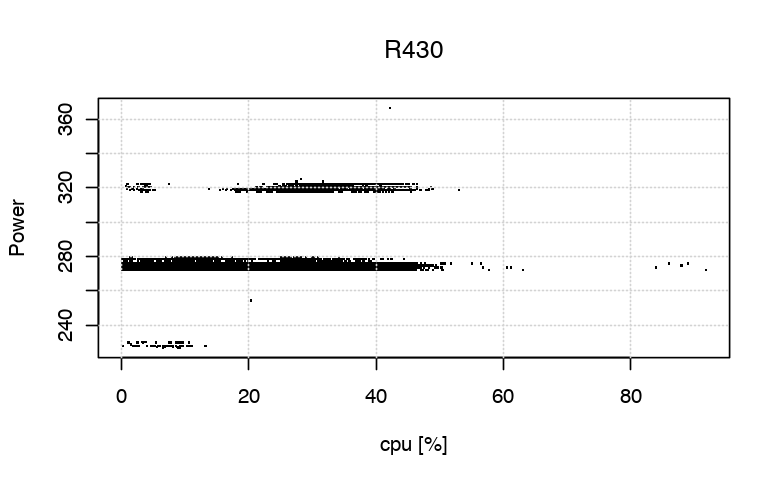

In [67]:
plot(merged_data_model$cpu, merged_data_model$total_power,xlab='cpu [%]',ylab='Power',pch='.')
title(chosen_model)
grid()

In [72]:
chosen_model=models[3]
model_data=data[which(data$model==chosen_model),]
hostnames=unique(model_data$hostname)
model_data_cpu= data_cpu[which(data_cpu$hostname %in% hostnames),]
q=which(model_data_cpu$timestamp <= max(model_data$timestamp))
model_data_cpu= model_data_cpu[q,]
merged_data_model=merge(model_data, model_data_cpu,by=c("timestamp","hostname"))
print (paste('Number of hosts in model ',chosen_model,' is ',length(hostnames),sep=""))
print('5 app hosts, 3 ffx, 1 monitor')

[1] "Number of hosts in model DL360P is 9"
[1] "5 app hosts, 3 ffx, 1 monitor"


In [73]:
qr <- rq(total_power ~ cpu, data=merged_data_model, tau = 0.95)
qr2 <- rq(total_power ~ cpu, data=merged_data_model, tau = 0.99)
print(paste('95Percentile quantile regression slope, intercept: ',format(round((qr$coefficients)[2], 2), nsmall = 2),",",format(round((qr$coefficients)[1], 2), nsmall = 2),sep=""))
print(paste('99Percentile quantile regression slope, intercept: ',format(round((qr2$coefficients)[2], 2), nsmall = 2),",",format(round((qr2$coefficients)[1], 2), nsmall = 2),sep=""))

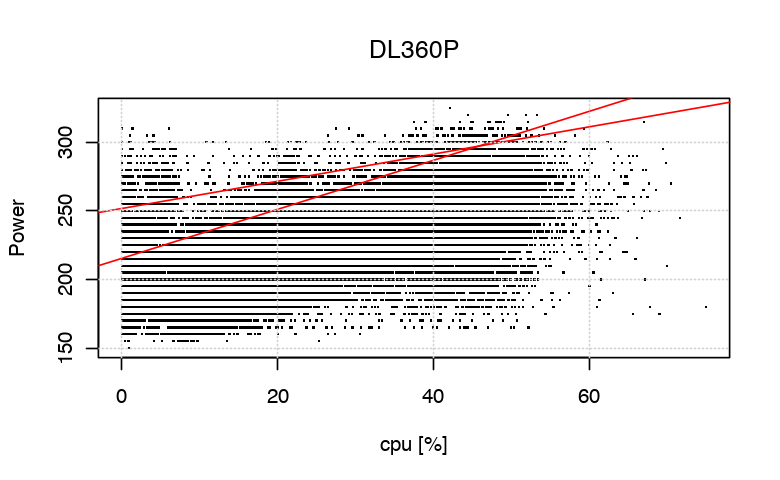

In [74]:
plot(merged_data_model$cpu, merged_data_model$total_power,xlab='cpu [%]',ylab='Power',pch='.')
abline(qr,col="red")
abline(qr2,col="red")
title(chosen_model)
grid()

In [75]:
chosen_model=models[5]
model_data=data[which(data$model==chosen_model),]
hostnames=unique(model_data$hostname)
model_data_cpu= data_cpu[which(data_cpu$hostname %in% hostnames),]
q=which(model_data_cpu$timestamp <= max(model_data$timestamp))
model_data_cpu= model_data_cpu[q,]
merged_data_model=merge(model_data, model_data_cpu,by=c("timestamp","hostname"))
print (paste('Number of hosts in model ',chosen_model,' is ',length(hostnames),sep=""))
print('1 dgdb host')
#hostnames

[1] "Number of hosts in model DL560 is 1"


[1] eu5-dgdb1-1-par.ops.sfdc.net
152 Levels: eu5-app1-1-par.ops.sfdc.net ... eu5-search43-5-par.ops.sfdc.net

In [77]:
qr <- rq(total_power ~ cpu, data=merged_data_model, tau = 0.95)
qr2 <- rq(total_power ~ cpu, data=merged_data_model, tau = 0.99)
print(paste('95Percentile quantile regression slope, intercept: ',format(round((qr$coefficients)[2], 2), nsmall = 2),",",format(round((qr$coefficients)[1], 2), nsmall = 2),sep=""))
print(paste('99Percentile quantile regression slope, intercept: ',format(round((qr2$coefficients)[2], 2), nsmall = 2),",",format(round((qr2$coefficients)[1], 2), nsmall = 2),sep=""))

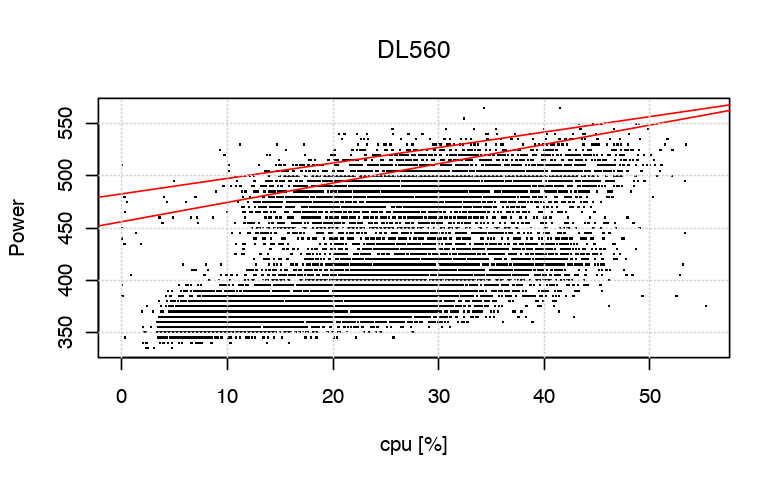

In [78]:
plot(merged_data_model$cpu, merged_data_model$total_power,xlab='cpu [%]',ylab='Power',pch='.')
abline(qr,col="red")
abline(qr2,col="red")
title(chosen_model)
grid()

Let's look at use case number 2 for EU5. We will look at the relation between power consumption and cpu per server type per role.
Let's start with app and DL360 Gen 9

In [111]:
chosen_model=models[1]
chosen_role='app'
model_data_role=data[which(data$model==chosen_model & data$role==chosen_role),]
hostnames=unique(model_data_role$hostname)
model_data_role_cpu= data_cpu[which(data_cpu$hostname %in% hostnames),]
q=which(model_data_role_cpu$timestamp <= max(model_data_role$timestamp))
model_data_role_cpu = model_data_role_cpu[q,]
merged_data_model_role=merge(model_data_role, model_data_role_cpu,by=c("timestamp","hostname"))
print (paste('Number of hosts in model ',chosen_model,' is ',length(hostnames),sep=""))

[1] "Number of hosts in model DL360 Gen9 is 25"


In [112]:
qr <- rq(total_power ~ cpu, data=merged_data_model_role, tau = 0.95)
qr2 <- rq(total_power ~ cpu, data=merged_data_model_role, tau = 0.99)
print(paste('95Percentile quantile regression slope, intercept: ',format(round((qr$coefficients)[2], 2), nsmall = 2),",",format(round((qr$coefficients)[1], 2), nsmall = 2),sep=""))
print(paste('99Percentile quantile regression slope, intercept: ',format(round((qr2$coefficients)[2], 2), nsmall = 2),",",format(round((qr2$coefficients)[1], 2), nsmall = 2),sep=""))

[1] "95Percentile quantile regression slope, intercept: 1.68,285.36"
[1] "99Percentile quantile regression slope, intercept: 1.49,311.76"


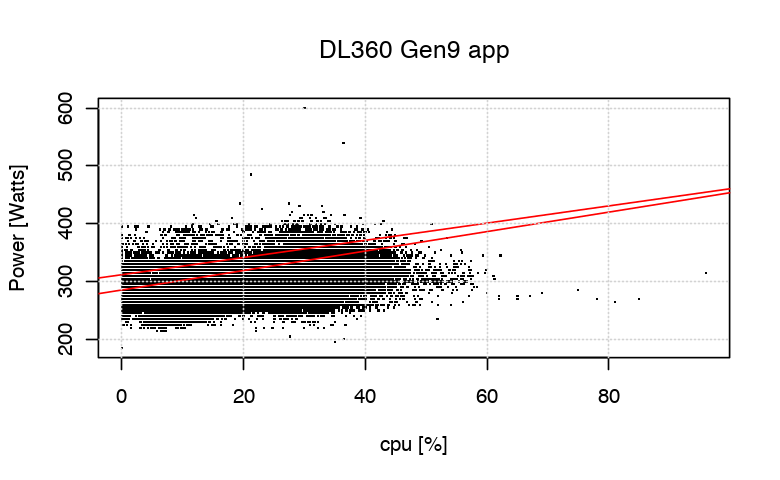

In [97]:
plot(merged_data_model_role$cpu, merged_data_model_role$total_power,xlab='cpu [%]',ylab='Power [Watts]',pch='.')
abline(qr,col="red")
abline(qr2,col="red")
title(paste(chosen_model," ",chosen_role,sep=""))
grid()

Now let's look at cbatch

In [114]:
chosen_model=models[1]
chosen_role='cbatch'
model_data_role=data[which(data$model==chosen_model & data$role==chosen_role),]
hostnames=unique(model_data_role$hostname)
model_data_role_cpu= data_cpu[which(data_cpu$hostname %in% hostnames),]
q=which(model_data_role_cpu$timestamp <= max(model_data_role$timestamp))
model_data_role_cpu = model_data_role_cpu[q,]
merged_data_model_role=merge(model_data_role, model_data_role_cpu,by=c("timestamp","hostname"))
print (paste('Number of hosts in model ',chosen_model,' is ',length(hostnames),sep=""))
#qr <- rq(total_power ~ cpu, data=merged_data_model_role, tau = 0.95)
#qr2 <- rq(total_power ~ cpu, data=merged_data_model_role, tau = 0.99)
#print(paste('95Percentile quantile regression slope, intercept: ',format(round((qr$coefficients)[2], 2), nsmall = 2),",",format(round((qr$coefficients)[1], 2), nsmall = 2),sep=""))
#print(paste('99Percentile quantile regression slope, intercept: ',format(round((qr2$coefficients)[2], 2), nsmall = 2),",",format(round((qr2$coefficients)[1], 2), nsmall = 2),sep=""))

[1] "Number of hosts in model DL360 Gen9 is 4"
[1] "95Percentile quantile regression slope, intercept: 1.65,273.32"
[1] "99Percentile quantile regression slope, intercept: 2.47,283.09"


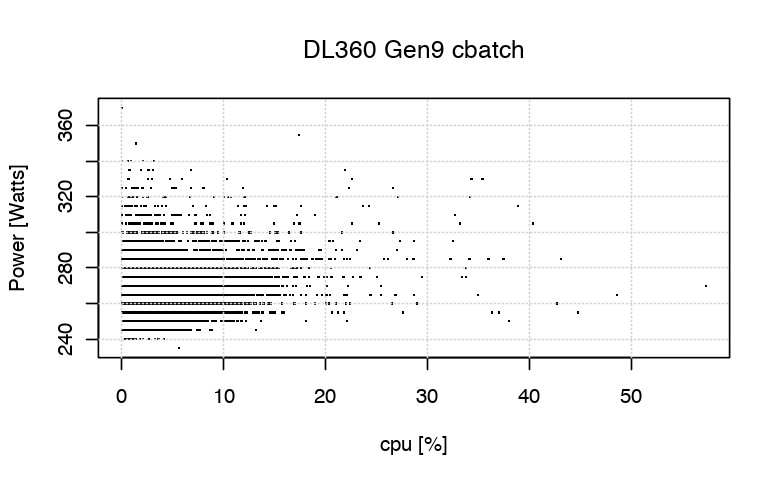

In [116]:
plot(merged_data_model_role$cpu, merged_data_model_role$total_power,xlab='cpu [%]',ylab='Power [Watts]',pch='.')
#abline(qr,col="red")
#abline(qr2,col="red")
title(paste(chosen_model," ",chosen_role,sep=""))
grid()

Let's look at ffx

[1] "Number of hosts in model DL360 Gen9 is 34"


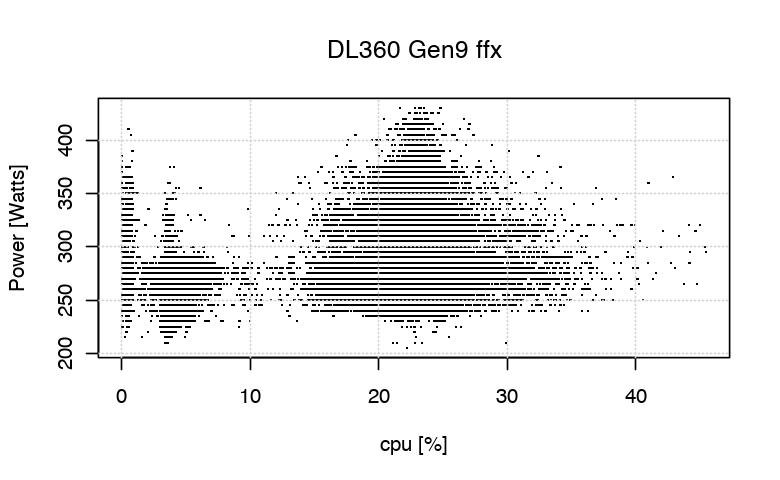

In [117]:
chosen_model=models[1]
chosen_role='ffx'
model_data_role=data[which(data$model==chosen_model & data$role==chosen_role),]
hostnames=unique(model_data_role$hostname)
model_data_role_cpu= data_cpu[which(data_cpu$hostname %in% hostnames),]
q=which(model_data_role_cpu$timestamp <= max(model_data_role$timestamp))
model_data_role_cpu = model_data_role_cpu[q,]
merged_data_model_role=merge(model_data_role, model_data_role_cpu,by=c("timestamp","hostname"))
print (paste('Number of hosts in model ',chosen_model,' is ',length(hostnames),sep=""))
plot(merged_data_model_role$cpu, merged_data_model_role$total_power,xlab='cpu [%]',ylab='Power [Watts]',pch='.')
#abline(qr,col="red")
#abline(qr2,col="red")
title(paste(chosen_model," ",chosen_role,sep=""))
grid()

Let's look at search

[1] "Number of hosts in model DL360 Gen9 is 30"


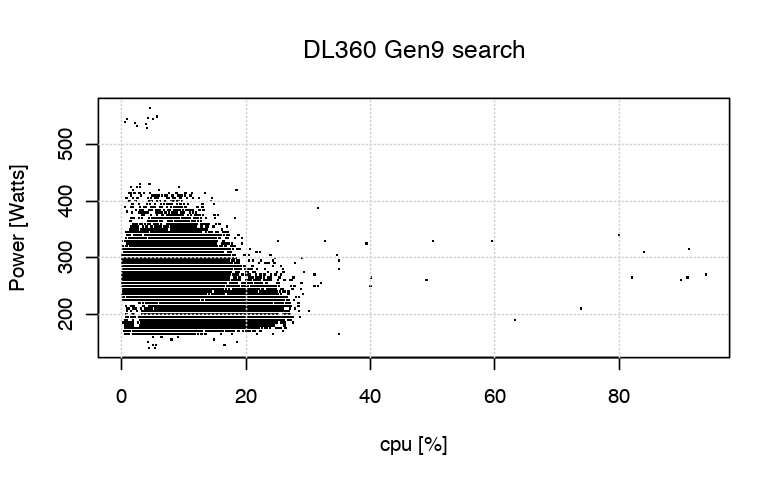

In [118]:
chosen_model=models[1]
chosen_role='search'
model_data_role=data[which(data$model==chosen_model & data$role==chosen_role),]
hostnames=unique(model_data_role$hostname)
model_data_role_cpu= data_cpu[which(data_cpu$hostname %in% hostnames),]
q=which(model_data_role_cpu$timestamp <= max(model_data_role$timestamp))
model_data_role_cpu = model_data_role_cpu[q,]
merged_data_model_role=merge(model_data_role, model_data_role_cpu,by=c("timestamp","hostname"))
print (paste('Number of hosts in model ',chosen_model,' is ',length(hostnames),sep=""))
plot(merged_data_model_role$cpu, merged_data_model_role$total_power,xlab='cpu [%]',ylab='Power [Watts]',pch='.')
#abline(qr,col="red")
#abline(qr2,col="red")
title(paste(chosen_model," ",chosen_role,sep=""))
grid()